In [111]:
from __future__ import division
import pickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd
import scipy
from scipy import stats

In [2]:
X_train = pd.read_csv("forty_column_dataset.csv")
X_test = pd.read_csv("data/X_test.csv")
X_train_old = pd.read_csv("data/X_train.csv")

In [4]:
X_test.shape

(303913, 30)

In [5]:
del X_test['SelectedPackage']
del X_test['TodayDate']
del X_test['ReceivedDateTime']
del X_test['Unnamed: 0']

In [16]:
npp_unique = np.unique(X_train_old['NameOfPolicyProduct'])
updated_npp = np.array([np.arange(len(npp_unique))[np.array(val==npp_unique, dtype=bool)][0] for val in X_test['NameOfPolicyProduct']])
X_test['NameOfPolicyProduct'] = updated_npp

In [21]:
scid_unique = np.unique(X_train_old['SCID'])
updated_scid = np.array([len(scid_unique)+1 if val not in scid_unique else \
                         np.arange(len(scid_unique))[np.array(val==scid_unique, dtype=bool)][0] for val in X_test['SCID']])
X_test['SCID'] = updated_scid

In [49]:
ids = np.array(X_test['CustomerMD5Key'])

In [50]:
a = scipy.stats.itemfreq(ids)
a_ids = np.array([x[0] for x in a])
a_freq = np.array([int(x[1]) for x in a])

keys = a_ids
values = a_freq
dictionary = dict(zip(keys, values))

In [54]:
customerkey_index = 0
pp_index = np.arange(len(X_test.columns))[np.array(X_test.columns) =='NameOfPolicyProduct' ][0]

master_pp = {i:[] for i in a_ids}

for idx, i in enumerate(np.array(X_test)):
    #if i[pp_index] not in master_pp[i[customerkey_index]]:
    master_pp[i[customerkey_index]].append(i[pp_index])
    
num_unique_pols = np.array([len(np.unique(master_pp.get(i))) for i in X_test['CustomerMD5Key']] )
num_total_pols =  np.array([len(master_pp.get(i)) for i in X_test['CustomerMD5Key']] )

In [56]:
cam_index = np.arange(len(X_test.columns))[np.array(X_test.columns) =='CarAnnualMileage'][0]
cmi_index = np.arange(len(X_test.columns))[np.array(X_test.columns) =='CarMakeId'][0]
ca_index = np.arange(len(X_test.columns))[np.array(X_test.columns) =='CarAge'][0]
civ_index = np.arange(len(X_test.columns))[np.array(X_test.columns) =='CarInsuredValue'][0]

master_cam = {i:[] for i in a_ids}
master_cmi = {i:[] for i in a_ids}
master_ca = {i:[] for i in a_ids}
master_civ = {i:[] for i in a_ids}

for idx, i in enumerate(np.array(X_test)):
    master_cam[i[customerkey_index]].append(i[cam_index])
    master_cmi[i[customerkey_index]].append(i[cmi_index])
    master_ca[i[customerkey_index]].append(i[ca_index])
    master_civ[i[customerkey_index]].append(i[civ_index])

In [57]:
num_unique_cam = np.array([len(np.unique(master_cam.get(i))) for i in X_test['CustomerMD5Key']] )
num_unique_cmi = np.array([len(np.unique(master_cmi.get(i))) for i in X_test['CustomerMD5Key']] )
num_unique_ca = np.array([len(np.unique(master_ca.get(i))) for i in X_test['CustomerMD5Key']] )
num_unique_civ = np.array([len(np.unique(master_civ.get(i))) for i in X_test['CustomerMD5Key']] )

In [58]:
car_con_1 = (num_unique_ca!=num_unique_civ)
car_con_2 = (num_unique_cam!=num_unique_civ)
car_con_3 = (num_unique_cmi!=num_unique_civ)
car_con_4 = (num_unique_cam!=num_unique_cmi)
car_con_5 = (num_unique_ca!=num_unique_cmi)
car_con_6 = (num_unique_cam!=num_unique_ca)

In [60]:
vendor_freq = scipy.stats.itemfreq(X_train['AffinityCodeId'])
log_vf = np.array([np.log10(x[1]) for x in vendor_freq])
vendor_keys = np.array([x[0] for x in vendor_freq])
vendor_values = [0 if x<1.5 else 1 if (x>=1.5)&(x<4) else 2 for x in log_vf]
vendor_dict  = dict(zip(vendor_keys, vendor_values))
vendor_log_sales = np.array([vendor_dict.get(x) for x in X_test['AffinityCodeId']])

In [61]:
vendor_values_unlogged = np.array([x[1] for x in vendor_freq])
success_mask = np.array(X_train['labels']==1)
vendor_success_scipy = scipy.stats.itemfreq(X_train['AffinityCodeId'][success_mask])
vendor_success_names = np.array([x[0] for x in vendor_success_scipy])
vendor_success_freqs = np.array([x[1] for x in vendor_success_scipy])
vendor_success_rates = np.array([0 if x not in vendor_success_names else \
                        vendor_success_freqs[vendor_success_names==x][0]/y  for x,y in zip(vendor_keys, vendor_values_unlogged)])
vendor_success_dict  = dict(zip(vendor_keys, vendor_success_rates))
vendor_success_final = np.array([vendor_success_dict.get(x) for x in X_test['AffinityCodeId']])

In [62]:
annual_milage_per_age = X_test['CarAnnualMileage']/(X_test['CarAge']+2)
voluntary_payment_per_value = X_test['VoluntaryExcess']/(X_test['CarInsuredValue']+1)

X_test['voluntary_payment_per_value'] = voluntary_payment_per_value
X_test['annual_milage_per_age'] = annual_milage_per_age
X_test['vendor_success_rate'] = vendor_success_final
X_test['vendor_log_sales'] = vendor_log_sales

X_test['age_minus_policy'] = X_test['FirstDriverAge'] - X_test['PolicyHolderNoClaimDiscountYears']

X_test['num_unique_pols'] = num_unique_pols
X_test['num_total_pols'] = num_total_pols 

X_test['car_flag_1'] = car_con_1
X_test['car_flag_2'] = car_con_2
X_test['car_flag_3'] = car_con_3
X_test['car_flag_4'] = car_con_4
X_test['car_flag_5'] = car_con_5
X_test['car_flag_6'] = car_con_6

In [80]:
X_test.replace([np.inf, -np.inf], np.nan)
X_test = X_test.fillna(method = 'ffill')

In [82]:
np.savez_compressed('juice_test.npz', X_test.ix[:, (X_test.columns != 'CustomerMD5Key')])

In [89]:
# X_train.columns

Index([u'Unnamed: 0', u'CustomerMD5Key', u'SCID', u'FirstDriverMaritalStatus',
       u'CarAnnualMileage', u'CarFuelId', u'CarUsageId', u'FirstDriverAge',
       u'CarInsuredValue', u'CarAge', u'FirstDriverDrivingLicenseNumberY',
       u'VoluntaryExcess', u'CarParkingTypeId',
       u'PolicyHolderNoClaimDiscountYears', u'FirstDriverDrivingLicenceType',
       u'CoverIsNoClaimDiscountSelected', u'CarDrivingEntitlement',
       u'CarTransmissionId', u'SocioDemographicId',
       u'PolicyHolderResidencyArea', u'AllDriversNbConvictions',
       u'RatedDriverNumber', u'IsPolicyholderAHomeowner', u'CarMakeId',
       u'DaysSinceCarPurchase', u'NameOfPolicyProduct', u'AffinityCodeId',
       u'labels', u'voluntary_payment_per_value', u'annual_milage_per_age',
       u'vendor_success_rate', u'vendor_log_sales', u'age_minus_policy',
       u'num_unique_pols', u'num_total_pols', u'car_flag_1', u'car_flag_2',
       u'car_flag_3', u'car_flag_4', u'car_flag_5', u'car_flag_6'],
      dtype='object

In [90]:
# X_test.ix[:, (X_test.columns != 'CustomerMD5Key')].columns

Index([u'SCID', u'FirstDriverMaritalStatus', u'CarAnnualMileage', u'CarFuelId',
       u'CarUsageId', u'FirstDriverAge', u'CarInsuredValue', u'CarAge',
       u'FirstDriverDrivingLicenseNumberY', u'VoluntaryExcess',
       u'CarParkingTypeId', u'PolicyHolderNoClaimDiscountYears',
       u'FirstDriverDrivingLicenceType', u'CoverIsNoClaimDiscountSelected',
       u'CarDrivingEntitlement', u'CarTransmissionId', u'SocioDemographicId',
       u'PolicyHolderResidencyArea', u'AllDriversNbConvictions',
       u'RatedDriverNumber', u'IsPolicyholderAHomeowner', u'CarMakeId',
       u'DaysSinceCarPurchase', u'NameOfPolicyProduct', u'AffinityCodeId',
       u'voluntary_payment_per_value', u'annual_milage_per_age',
       u'vendor_success_rate', u'vendor_log_sales', u'age_minus_policy',
       u'num_unique_pols', u'num_total_pols', u'car_flag_1', u'car_flag_2',
       u'car_flag_3', u'car_flag_4', u'car_flag_5', u'car_flag_6'],
      dtype='object')

In [96]:
# X_test.shape

(303913, 39)

In [97]:
# X_train.shape

(2911270, 41)

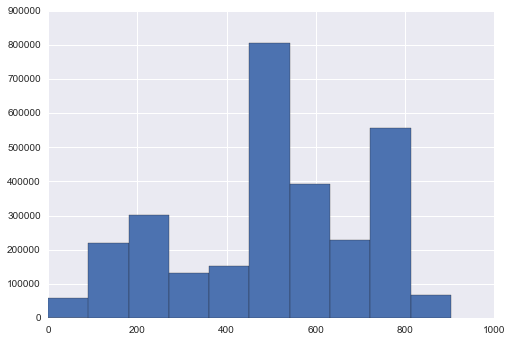

(array([  6506.,  23045.,  30854.,  12669.,  16510.,  86874.,  38997.,
         23405.,  58068.,   6985.]),
 array([   2. ,   92.4,  182.8,  273.2,  363.6,  454. ,  544.4,  634.8,
         725.2,  815.6,  906. ]),
 <a list of 10 Patch objects>)

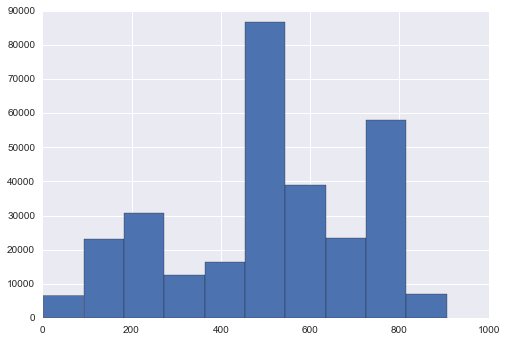

In [105]:
# plt.hist(X_train['SCID'])
# plt.show()
# plt.hist(X_test['SCID'])

In [107]:
forty_col_test = np.load('juice_test.npz')

In [110]:
# forty_col_test['arr_0'].shape()

TypeError: 'tuple' object is not callable

In [87]:
X_test.to_csv("juice_test.csv")

In [73]:
c = X_test

In [78]:
# c.shape

(303913, 39)

In [81]:
# X_test

,CustomerMD5Key,SCID,FirstDriverMaritalStatus,CarAnnualMileage,CarFuelId,CarUsageId,FirstDriverAge,CarInsuredValue,CarAge,FirstDriverDrivingLicenseNumberY,...,vendor_log_sales,age_minus_policy,num_unique_pols,num_total_pols,car_flag_1,car_flag_2,car_flag_3,car_flag_4,car_flag_5,car_flag_6
0,0x94c43ba3c2ce6ed5291dcbaa86fd3fc5,226,2.0,4001.0,1.0,0.0,56.0,1001.0,9.0,30.0,...,2,36.0,5,17,False,False,False,False,False,False
1,0xe07f462984048f4997036dcfe93091c4,552,2.0,4001.0,2.0,4.0,55.0,3001.0,10.0,24.0,...,2,47.0,5,12,False,False,False,False,False,False
2,0x4c59bc59bc23a00e7c9bd64c20c3b3a2,17,2.0,9001.0,1.0,0.0,44.0,1001.0,11.0,20.0,...,2,40.0,1,51,False,False,False,False,False,False
3,0x3b0045113940e7daafec72335ddc9db4,509,2.0,8001.0,2.0,4.0,70.0,3001.0,8.0,25.0,...,2,61.0,1,30,False,False,False,False,False,False
4,0xac224fc74ca238165683a715220a6cf4,508,3.0,4001.0,1.0,0.0,25.0,3001.0,5.0,5.0,...,2,20.0,1,8,False,False,False,False,False,False
5,0xcde4b81278dc724e21c25450c246529f,260,2.0,4001.0,1.0,4.0,66.0,2001.0,11.0,30.0,...,2,61.0,4,17,False,False,False,False,False,False
6,0x604652c7219f717784f53df17a9d63fc,690,2.0,10001.0,1.0,1.0,38.0,1001.0,12.0,19.0,...,2,32.0,4,47,False,False,False,False,False,False
7,0x056579e23553dab3d14f5ca03f65964f,797,2.0,7001.0,2.0,0.0,44.0,2001.0,10.0,20.0,...,2,29.0,4,52,True,False,True,True,False,True
8,0x53fa0e823ef7f1e07836f553001ea9a9,379,3.0,3001.0,1.0,4.0,34.0,0.0,14.0,5.0,...,2,29.0,1,59,False,False,False,False,False,False
9,0xd546892d144eb1d412cf8477ceff777f,498,1.0,2001.0,2.0,0.0,36.0,2001.0,8.0,15.0,...,2,32.0,5,114,False,False,False,False,False,False
